In [1]:
from pytorch_lightning.utilities.seed import seed_everything
RANDOM_SEED = 42
seed_everything(seed=RANDOM_SEED)

Global seed set to 42


42

In [110]:
import pandas as pd
metrics_df = pd.read_csv("results.csv", index_col=0)

# Data loading

In [4]:
import mirdata
from mir_eval.util import merge_labeled_intervals, adjust_intervals
from tqdm import tqdm

billboard = mirdata.initialize('billboard')
billboard.download()
tracks = billboard.load_tracks()

dataset = list()

for i, track in tqdm(tracks.items()):
    try:
        section_intervals = track.named_sections.intervals
        sections = track.named_sections.labels

        # adjust chord intervals to match
        chord_intervals, chords = adjust_intervals(track.chords_full.intervals, 
                                                   labels=track.chords_full.labels, 
                                                   t_min=section_intervals.min(), 
                                                   t_max=section_intervals.max(), 
                                                   start_label="N", 
                                                   end_label="N")

        _, sections, chords = merge_labeled_intervals(section_intervals, sections, chord_intervals, chords)
        dataset.append((chords, sections))
    except Exception as e:
        print("Track", i, "not parsable")

INFO: Downloading ['metadata', 'annotation_salami', 'annotation_lab', 'annotation_mirex13', 'annotation_chordino'] to /home/nicolas/mir_datasets/billboard
INFO: [metadata] downloading billboard-2.0-index.csv
INFO: /home/nicolas/mir_datasets/billboard/billboard-2.0-index.csv already exists and will not be downloaded. Rerun with force_overwrite=True to delete this file and force the download.
INFO: [annotation_salami] downloading billboard-2.0-salami_chords.tar.gz
INFO: /home/nicolas/mir_datasets/billboard/billboard-2.0-salami_chords.tar.gz already exists and will not be downloaded. Rerun with force_overwrite=True to delete this file and force the download.
INFO: [annotation_lab] downloading billboard-2.0.1-lab.tar.gz
INFO: /home/nicolas/mir_datasets/billboard/billboard-2.0.1-lab.tar.gz already exists and will not be downloaded. Rerun with force_overwrite=True to delete this file and force the download.
INFO: [annotation_mirex13] downloading billboard-2.0.1-mirex.tar.gz
INFO: /home/nicol

Track 974 not parsable


100%|██████████| 890/890 [00:00<00:00, 1043.60it/s]


In [5]:
from itertools import chain

sections = list(chain(*[s for _, s in dataset]))
print(f"Total of {len(sections)} annotations - {len(set(sections))} unique")

Total of 148394 annotations - 80 unique


Unify most sections as possible.

In [6]:
import re
import functools
import string

SYMBOLS_RE = re.compile("[" + re.escape(string.punctuation) + "]")
NUMBERS_RE = re.compile("[" + re.escape(string.digits) + "]")
CONSECUTIVE_SPACES_RE = re.compile(r"\s+")

VERSE_RE = re.compile(r"(verse)")
PRECHORUS_RE = re.compile(r"(prechorus|pre chorus)")
CHORUS_RE = re.compile(r"(chorus)")
INTRO_RE = re.compile(r"(fadein|fade in|intro)")
OUTRO_RE = re.compile(r"(outro|coda|fadeout|fade-out|ending)")
INSTRUMENTAL_RE = re.compile(r"""(applause|bass|choir|clarinet|drums|flute|harmonica|harpsichord|
                                  instrumental|instrumental break|noise|oboe|organ|piano|rap|
                                  saxophone|solo|spoken|strings|synth|synthesizer|talking|
                                  trumpet|vocal|voice|guitar|saxophone|trumpet)""")
THEME_RE = re.compile(r"(main theme|theme|secondary theme)")
TRANSITION_RE = re.compile(r"(transition|trans)")
OTHER_RE = re.compile(r"(modulation|key change)")

def preprocess_section(section):
    # remove symbols, numbers and spaces
    section = SYMBOLS_RE.sub(" ", section)
    section = NUMBERS_RE.sub(" ", section)
    section = CONSECUTIVE_SPACES_RE.sub(" ", section)

    section = "verse" if VERSE_RE.search(section) else section
    section = "prechorus" if PRECHORUS_RE.search(section) else section
    section = "chorus" if CHORUS_RE.search(section) else section
    section = "intro" if INTRO_RE.search(section) else section
    section = "outro" if OUTRO_RE.search(section) else section
    section = "instrumental" if INSTRUMENTAL_RE.search(section) else section
    section = "theme" if THEME_RE.search(section) else section
    section = "transition" if TRANSITION_RE.search(section) else section
    section = "other" if OTHER_RE.search(section) else section

    section = section.strip()
    return section

In [7]:
from collections import Counter
sorted(Counter([preprocess_section(s) for s in sections]).items(), key=lambda i: i[1], reverse=True)

[('verse', 50310),
 ('chorus', 46495),
 ('instrumental', 13878),
 ('outro', 11852),
 ('intro', 10273),
 ('bridge', 7029),
 ('interlude', 5038),
 ('transition', 2773),
 ('theme', 446),
 ('refrain', 247),
 ('other', 53)]

In [8]:
dataset = [
  (chords, [preprocess_section(s) for s in sections])
  for chords, sections in dataset
]

## Visualize section annotations

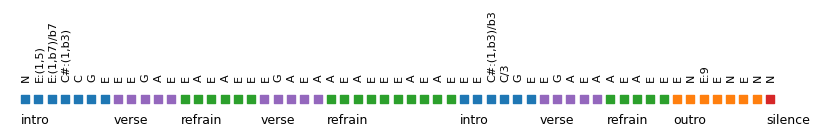

In [234]:
import matplotlib.pyplot as plt
from more_itertools import windowed
import numpy as np

def plot_segmentation(seq, y_base=1, title="", show_content=False, ax=None):
  if ax is None:
    _, ax = plt.subplots()
  
  sections, seg = np.unique([ann.section for ann in seq.annotations], return_inverse=True)
  positions = [(label, np.where(seg == label)[0]) for label in np.unique(seg)]
  
  colors = [plt.get_cmap('gist_rainbow')(i) for i in np.linspace(0, 1, len(positions))]
  markers = [marker for _, marker in plt.Line2D.markers.items() if marker != "nothing"]
  for idx, (lbl, idxs) in enumerate(positions):           
    ax.scatter(idxs, np.full_like(idxs, y_base), marker="s", s=40, label=sections[idx])
    
    text_points = [g[0] for g in np.split(idxs, np.where(np.diff(idxs) != 1)[0]+1)]
    for i in text_points:
      ax.text(i - 0.3, y_base - 1.3, sections[idx], size=9, family="Libertinus")

    for i in idxs:
      ax.text(i - 0.3, y_base + 1, seq.annotations[i].chord.symbol, rotation=90, size=8)
  
  #ax.legend(loc="upper left", ncol=len(sections))
  ax.axis("off")
  ax.set_ylim(0, 4)
  ax.set_title(title)
  ax.margins(0.02)

fig, ax = plt.subplots(figsize=(10, 1))
helter = next(filter(lambda doc: doc.jams.file_metadata.title == "Helter Skelter", simplified_dataset))
plot_segmentation(helter, show_content=False, ax=ax)
fig.savefig("helterskelter.png")

# Data preparation

In [9]:
from sklearn.model_selection import train_test_split

X, y = zip(*dataset)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=RANDOM_SEED)

Pad all the sequences to the longest sequence in the split and encode them using the embedding.

In [10]:
import torch
from torch.nn.utils.rnn import pad_sequence
from sklearn.preprocessing import OneHotEncoder
import numpy as np

labels = list(set.union(*[set(yi) for yi in y_train]))
encoder = OneHotEncoder().fit(np.array(labels).reshape(-1, 1))

def embed_data(model, X, y, encoder):
    seq_length = [len(xi) for xi in X]
    max_seq_length = max(seq_length)
    
    padded_seq = np.stack(
        [np.pad(xi, (0, max_seq_length - len(xi)), constant_values="P") 
         for xi in X])
    
    padding_mask = torch.tensor((padded_seq == "P").astype(int))
    padded_seq[padding_mask == 1] = "N"
    
    embedded_seq = torch.tensor(np.stack([[model[sample]
                                         for sample in seq] 
                                        for seq in padded_seq]))
    
    
    encoded_labels = [torch.tensor(encoder.transform(np.array(yi).reshape(-1, 1)).todense()) for yi in y]
    padded_labels = pad_sequence(encoded_labels, batch_first=True, padding_value=0)
  
    return embedded_seq, padded_labels, padding_mask

# FORM Baseline

In [112]:
from segmentation.form import FORM
from mir_eval.util import boundaries_to_intervals
from mir_eval.segment import pairwise, nce
import numpy as np

In [119]:
metrics = list()

def simplify_chord(chord):
    if ":" not in chord:
        root = chord
        sh = "maj"
    else:
        root, sh = chord.split(":")
        sh = "min" if "min" in sh else "maj"
    return root + ":" + sh

for xi, yi in zip(X_test, y_test):
    intervals = boundaries_to_intervals(np.arange(len(yi) + 1))
    # Transformed chords
    _, pred = np.unique(FORM([simplify_chord(c) for c in list(xi)]), return_inverse=True)
    
    # Raw chords
    #_, pred = np.unique(FORM(list(xi)), return_inverse=True)
    
    _, target = np.unique(yi, return_inverse=True)
    
    pairwise_score = pairwise(intervals, target, intervals, pred)
    nce_score = pairwise(intervals, target, intervals, pred)

    metrics.append((*pairwise_score, *nce_score))
    
metrics_df.loc["FORM - simplified chords"] = [np.mean(m) for m in zip(*metrics)]

In [120]:
metrics_df

,p_precision,p_recall,p_f1,over,under,under_over_f1
FORM,0.667640,0.338019,0.425610,0.667640,0.338019,0.425610
pitchclass2vec,0.402290,0.953399,0.547694,0.719733,0.431959,0.537879
word2vec,0.410190,0.823330,0.523692,0.605202,0.257582,0.360186
fasttext,0.373044,0.993201,0.526918,0.947381,0.154424,0.264553
pitchclass2vec + word2vec,0.467940,0.664824,0.532202,0.544820,0.415806,0.471398
pitchclass2vec + fasttext,0.433019,0.835007,0.553045,0.539774,0.425738,0.473986
FORM - raw chords,0.681281,0.325479,0.416651,0.681281,0.325479,0.416651
FORM - simplified chords,0.667640,0.338019,0.425610,0.667640,0.338019,0.425610


# LSTM Model

## Model definition

In [11]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [12]:
import torch.nn as nn
import torch
import pytorch_lightning as pl
from mir_eval.util import boundaries_to_intervals
from mir_eval.segment import pairwise, nce
from collections import defaultdict
from more_itertools import stagger

class BaselineModel(pl.LightningModule):
    def __init__(self, 
                 embedding_dim: int = 10,
                 hidden_size: int = 100, 
                 dropout: float = 0.0,
                 num_layers: int = 1, 
                 num_labels: int = 11):
        super().__init__()
        self.save_hyperparameters()
        self.lstm = nn.LSTM(embedding_dim,
                            hidden_size,
                            dropout=dropout,
                            num_layers=num_layers,
                            batch_first=True)
        self.classification = nn.Linear(hidden_size, num_labels)
        self.softmax = nn.Softmax(dim=2)
        
    def _predict(self, batch):
        x, y, mask = batch
        x, _ = self.lstm(x)
        x = self.classification(x)
        x = self.softmax(x)
               
        loss = nn.functional.binary_cross_entropy(x[mask == 0].float(), y[mask == 0].float())
        return x, loss
    
    def _test(self, batch):
        metrics = defaultdict(list)
        mask = batch[-1]
        y = batch[-2]
        
        with torch.no_grad():
            pred, loss = self._predict(batch)
            
            for pi, yi, mi in zip(pred, y, mask):               
                pi = pi[mi == 0].argmax(axis=-1).cpu().numpy()
                _, pi = np.unique(pi, return_inverse=True)
            
                yi = yi[mi == 0].argmax(axis=-1).cpu().numpy()
                _, yi = np.unique(yi, return_inverse=True)
            
                intervals = boundaries_to_intervals(np.arange(len(yi) + 1))
                precision, recall, f1 = pairwise(intervals, yi, intervals, pi)
                metrics["p_precision"].append(precision)
                metrics["p_recall"].append(recall)
                metrics["p_f1"].append(f1)
                over, under, under_over_f1 = nce(intervals, yi, intervals, pi)
                metrics["under"] = under
                metrics["over"] = over
                metrics["under_over_f1"] = under_over_f1
        
        metrics = {k: np.mean(v) for k, v in metrics.items()}
        return loss, metrics

    def training_step(self, batch, batch_idx):
        _, loss = self._predict(batch)
        self.log("train_loss", loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        loss, metrics = self._test(batch)
        self.log("val_loss", loss)
        for k, m in metrics.items(): self.log(f"val_{k}", m)
        return loss
    
    def test_step(self, batch, batch_idx):
        loss, metrics = self._test(batch)        
        self.log("test_loss", loss)
        for k, m in metrics.items(): self.log(f"test_{k}", m)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.01)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "train_loss"
            }
        }

In [13]:
from torch.utils.data import DataLoader

class DataModule(pl.LightningDataModule):
    def __init__(self, train, valid = None, test = None, batch_size: int = 128):
        super().__init__()
        self._train = train
        self._valid = valid
        self._test = test
        self.batch_size = batch_size
        
    def train_dataloader(self):
        return DataLoader(list(zip(*self._train)), batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        if self._valid is not None:
            return DataLoader(list(zip(*self._valid)), batch_size=self.batch_size, shuffle=True)
        
    def test_dataloader(self):
        if self._test is not None:
            return DataLoader(list(zip(*self._test)), batch_size=self.batch_size, shuffle=True)

In [14]:
from pytorch_lightning.callbacks import EarlyStopping, StochasticWeightAveraging
import logging

logging.getLogger("pytorch_lightning").setLevel(logging.CRITICAL)


def train(config, data, epochs=500, validate=True, log=False):
    model = BaselineModel(**config)
    
    trainer = pl.Trainer(max_epochs=epochs, accelerator="gpu", devices=1,
                         enable_progress_bar=False,
                         callbacks=[
                             EarlyStopping(monitor="val_loss", patience=2),
                             StochasticWeightAveraging(swa_lrs=1e-2)
                         ])
    trainer.fit(model, datamodule=data)
    results = trainer.validate(model, datamodule=data, verbose=False) if validate else None
    return results, model

## Train using pitchclass2vec

In [24]:
from harte2vec.harte2vec import Harte2Vec
harte2vec = Harte2Vec.from_pretrained("harte2vec.pt")

data = DataModule(embed_data(harte2vec, X_train, y_train, encoder), 
                  embed_data(harte2vec, X_valid, y_valid, encoder), 
                  embed_data(harte2vec, X_test, y_test, encoder))

### Hyperparameter search

In [27]:
from itertools import product
from tqdm.auto import tqdm

parameters = { 
    "hidden_size": [50, 100, 150],
    "num_layers": [5, 10],
    "dropout": [0.0, 0.3, 0.5],
}

results = list()
combinations = list(enumerate(product(*parameters.values())))


for idx, params in tqdm(combinations):
    params = dict(zip(parameters.keys(), params))
    res, _ = train(params, data=data, epochs=350)
    results.append((params, res))

  0%|          | 0/18 [00:00<?, ?it/s]

/home/nicolas/harte2vec/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:489: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(
/home/nicolas/harte2vec/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/nicolas/harte2vec/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` 

In [28]:
import pandas as pd

df = pd.DataFrame.from_dict([dict(**res[0], **res[1][0]) for res in results])
df.iloc[(df["val_under_over_f1"] + df["val_p_f1"]).sort_values(ascending=False).index]

,hidden_size,num_layers,dropout,val_loss,val_p_precision,val_p_recall,val_p_f1,val_under,val_over,val_under_over_f1
9,100,10,0.0,0.229476,0.402938,0.924687,0.542306,0.468613,0.869995,0.609126
11,100,10,0.5,0.379196,0.383056,0.985740,0.535106,0.431746,0.926071,0.588927
7,100,5,0.3,0.206266,0.468261,0.657557,0.528840,0.464924,0.745115,0.572579
0,50,5,0.0,0.206874,0.467846,0.638917,0.521438,0.554509,0.496097,0.523680
4,50,10,0.3,0.210808,0.445388,0.799249,0.553248,0.445858,0.417985,0.431471
10,100,10,0.3,0.207082,0.460984,0.640401,0.516844,0.341888,0.525435,0.414240
6,100,5,0.0,0.207524,0.463266,0.648492,0.521674,0.378933,0.400630,0.389480
14,150,5,0.5,0.207147,0.442789,0.672500,0.509082,0.300011,0.601093,0.400252
2,50,5,0.5,0.212051,0.442703,0.767530,0.535488,0.223527,0.968607,0.363231
12,150,5,0.0,0.211003,0.450886,0.669630,0.521146,0.285601,0.505966,0.365109


### Test best hyperparameters

In [29]:
from harte2vec.harte2vec import Harte2Vec
harte2vec = Harte2Vec.from_pretrained("harte2vec.pt")

data = DataModule(embed_data(harte2vec, np.concatenate([X_train, X_valid]), np.concatenate([y_train, y_valid]), encoder),
                  test=embed_data(harte2vec, X_test, y_test, encoder))

<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [38]:
model = BaselineModel(hidden_size=100, num_layers=10, dropout=0.0)

trainer = pl.Trainer(default_root_dir="models/harte2vec_lstm",
                     max_epochs=350, accelerator="gpu", devices=1,
                     callbacks=[
                         EarlyStopping(monitor="train_loss", patience=2),
                         StochasticWeightAveraging(swa_lrs=1e-2),
                     ])

trainer.fit(model, datamodule=data)

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

In [45]:
metrics = trainer.test(model, datamodule=data)[0]

/home/nicolas/harte2vec/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:489: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(
/home/nicolas/harte2vec/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.2182684689760208
        test_over           0.7197334516110564
        test_p_f1           0.5476936269975969
    test_p_precision        0.4022895162419085
      test_p_recall         0.9533992693402393
       test_under           0.43195892501478533
   test_under_over_f1       0.5378787806221205
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [46]:
metrics_df.loc["pitchclass2vec"] = [
    metrics["test_p_precision"],
    metrics["test_p_recall"],
    metrics["test_p_f1"],
    metrics["test_over"],
    metrics["test_under"],
    metrics["test_under_over_f1"]
]

## Train using word2vec

In [32]:
class Word2VecWithOOV(object):
    """
    Add OOV support to Word2Vec by creating random embeddings when a token is not available in the vocab
    """
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.oov = dict()
        
    def __getitem__(self, idx):
        try:
            return self.word2vec.wv[idx]
        except:
            return self.oov.setdefault(idx, np.random.random(self.word2vec.vector_size).astype(np.float32))

In [71]:
from gensim.models import Word2Vec
word2vec = Word2VecWithOOV(Word2Vec.load("word2vec.gensim"))

data = DataModule(embed_data(word2vec, X_train, y_train, encoder), 
                  embed_data(word2vec, X_valid, y_valid, encoder), 
                  embed_data(word2vec, X_test, y_test, encoder))

INFO: loading Word2Vec object from word2vec.gensim
INFO: loading wv recursively from word2vec.gensim.wv.* with mmap=None
INFO: setting ignored attribute cum_table to None
INFO: Word2Vec lifecycle event {'fname': 'word2vec.gensim', 'datetime': '2022-10-16T23:00:03.122657', 'gensim': '4.2.0', 'python': '3.10.6 (main, Aug 10 2022, 11:40:04) [GCC 11.3.0]', 'platform': 'Linux-5.15.0-50-generic-x86_64-with-glibc2.35', 'event': 'loaded'}


### Hyperparameter search

In [72]:
from itertools import product
from tqdm.auto import tqdm

parameters = { 
    "hidden_size": [100, 150, 200],
    "num_layers": [5, 10],
    "dropout": [0.0, 0.3, 0.5],
    "embedding_dim": [word2vec.word2vec.vector_size]
}

results = list()
combinations = list(enumerate(product(*parameters.values())))

for idx, params in tqdm(combinations):
    params = dict(zip(parameters.keys(), params))
    res, _ = train(params, data=data, epochs=500)
    results.append((params, res))

  0%|          | 0/18 [00:00<?, ?it/s]

/home/nicolas/harte2vec/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:489: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(
/home/nicolas/harte2vec/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/nicolas/harte2vec/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` 

In [74]:
import pandas as pd

df = pd.DataFrame.from_dict([dict(**res[0], **res[1][0]) for res in results])
df.iloc[(df["val_under_over_f1"] + df["val_p_f1"]).sort_values(ascending=False).index]

,hidden_size,num_layers,dropout,embedding_dim,val_loss,val_p_precision,val_p_recall,val_p_f1,val_under,val_over,val_under_over_f1
1,100,5,0.3,300,0.228274,0.407020,0.896699,0.539775,0.484076,0.825031,0.610153
13,200,5,0.3,300,0.209259,0.435286,0.826174,0.551536,0.398382,0.894175,0.551191
17,200,10,0.5,300,0.210735,0.436684,0.663283,0.502034,0.483411,0.762158,0.591594
16,200,10,0.3,300,0.212370,0.463753,0.665777,0.528393,0.492006,0.593517,0.538015
9,150,10,0.0,300,0.210050,0.424819,0.700621,0.504443,0.406567,0.879817,0.556140
7,150,5,0.3,300,0.210393,0.446314,0.649735,0.506281,0.527091,0.584188,0.554173
15,200,10,0.0,300,0.210197,0.455316,0.634038,0.510683,0.420649,0.619771,0.501155
4,100,10,0.3,300,0.211976,0.417263,0.785236,0.522752,0.365776,0.679509,0.475561
8,150,5,0.5,300,0.212753,0.434484,0.833465,0.552536,0.280218,0.640084,0.389792
6,150,5,0.0,300,0.235202,0.391719,0.969264,0.540355,0.239728,0.937589,0.381829


### Test best hyperparameters

In [75]:
from gensim.models import Word2Vec
word2vec = Word2VecWithOOV(Word2Vec.load("word2vec.gensim"))

data = DataModule(embed_data(word2vec, np.concatenate([X_train, X_valid]), np.concatenate([y_train, y_valid]), encoder),
                  test=embed_data(word2vec, X_test, y_test, encoder))

INFO: loading Word2Vec object from word2vec.gensim
INFO: loading wv recursively from word2vec.gensim.wv.* with mmap=None
INFO: setting ignored attribute cum_table to None
INFO: Word2Vec lifecycle event {'fname': 'word2vec.gensim', 'datetime': '2022-10-16T23:08:57.865775', 'gensim': '4.2.0', 'python': '3.10.6 (main, Aug 10 2022, 11:40:04) [GCC 11.3.0]', 'platform': 'Linux-5.15.0-50-generic-x86_64-with-glibc2.35', 'event': 'loaded'}
<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [77]:
from pytorch_lightning.callbacks import EarlyStopping, StochasticWeightAveraging
import logging

logging.getLogger("pytorch_lightning").setLevel(logging.CRITICAL)

model = BaselineModel(hidden_size=100, num_layers=5, dropout=0.3, embedding_dim=word2vec.word2vec.vector_size)

trainer = pl.Trainer(default_root_dir="models/word2vec_lstm",
                     max_epochs=500, accelerator="gpu", devices=1,
                     callbacks=[
                         EarlyStopping(monitor="train_loss", patience=2),
                         StochasticWeightAveraging(swa_lrs=1e-2),
                     ])

trainer.fit(model, datamodule=data)

Sanity Checking: 0it [00:00, ?it/s]

/home/nicolas/harte2vec/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:374: UserWarning: One of given dataloaders is None and it will be skipped.
  rank_zero_warn("One of given dataloaders is None and it will be skipped.")
/home/nicolas/harte2vec/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/nicolas/harte2vec/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1892: PossibleUserWarning: The number of training batches (7) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero

Training: 0it [00:00, ?it/s]

In [80]:
metrics = trainer.test(model, datamodule=data)[0]

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.22714340686798096
        test_over           0.6052015215798109
        test_p_f1           0.5236918504469334
    test_p_precision        0.41019023779742786
      test_p_recall         0.8233300369569243
       test_under           0.2575823528843526
   test_under_over_f1       0.36018639689577925
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [81]:
metrics_df.loc["word2vec"] = [
    metrics["test_p_precision"],
    metrics["test_p_recall"],
    metrics["test_p_f1"],
    metrics["test_over"],
    metrics["test_under"],
    metrics["test_under_over_f1"]
]

## Train using fasttext

In [16]:
from gensim.models import FastText
fasttext = FastText.load("fasttext.gensim")

data = DataModule(embed_data(fasttext.wv, X_train, y_train, encoder), 
                  embed_data(fasttext.wv, X_valid, y_valid, encoder), 
                  embed_data(fasttext.wv, X_test, y_test, encoder))

INFO: loading FastText object from fasttext.gensim
INFO: loading wv recursively from fasttext.gensim.wv.* with mmap=None
INFO: loading vectors_ngrams from fasttext.gensim.wv.vectors_ngrams.npy with mmap=None
INFO: setting ignored attribute buckets_word to None
INFO: setting ignored attribute vectors to None
INFO: setting ignored attribute cum_table to None
INFO: FastText lifecycle event {'fname': 'fasttext.gensim', 'datetime': '2022-10-16T22:06:59.802031', 'gensim': '4.2.0', 'python': '3.10.6 (main, Aug 10 2022, 11:40:04) [GCC 11.3.0]', 'platform': 'Linux-5.15.0-50-generic-x86_64-with-glibc2.35', 'event': 'loaded'}


### Hyperparameter search

In [19]:
from itertools import product
from tqdm.auto import tqdm

parameters = { 
    "hidden_size": [100, 150, 200],
    "num_layers": [5, 10],
    "dropout": [0.0, 0.3, 0.5],
    "embedding_dim": [fasttext.vector_size]
}

results = list()
combinations = list(enumerate(product(*parameters.values())))

for idx, params in tqdm(combinations):
    params = dict(zip(parameters.keys(), params))
    res, _ = train(params, data=data, epochs=500)
    results.append((params, res))

  0%|          | 0/18 [00:00<?, ?it/s]

/home/nicolas/harte2vec/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:489: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(
/home/nicolas/harte2vec/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/nicolas/harte2vec/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` 

In [20]:
import pandas as pd

df = pd.DataFrame.from_dict([dict(**res[0], **res[1][0]) for res in results])
df.iloc[(df["val_under_over_f1"] + df["val_p_f1"]).sort_values(ascending=False).index]

,hidden_size,num_layers,dropout,embedding_dim,val_loss,val_p_precision,val_p_recall,val_p_f1,val_under,val_over,val_under_over_f1
2,100,5,0.5,300,0.209375,0.447328,0.749745,0.542312,0.599610,0.772591,0.675198
15,200,10,0.0,300,0.211436,0.427492,0.678706,0.499612,0.520195,0.904884,0.660618
16,200,10,0.3,300,0.211430,0.461277,0.680401,0.531454,0.452998,0.870582,0.595917
6,150,5,0.0,300,0.222038,0.418873,0.888039,0.552813,0.388325,0.738670,0.509042
1,100,5,0.3,300,0.206075,0.458311,0.641522,0.515893,0.469534,0.611469,0.531184
7,150,5,0.3,300,0.205404,0.467184,0.650102,0.524858,0.381980,0.629538,0.475466
8,150,5,0.5,300,0.207609,0.439195,0.661919,0.503722,0.459985,0.484423,0.471888
4,100,10,0.3,300,0.206482,0.444256,0.770768,0.545426,0.332280,0.574529,0.421047
10,150,10,0.3,300,0.207764,0.463528,0.643898,0.519913,0.401626,0.499267,0.445155
3,100,10,0.0,300,0.208622,0.452126,0.631323,0.504884,0.336085,0.708227,0.455849


### Test best hyperparameters

In [83]:
from gensim.models import FastText
fasttext = FastText.load("fasttext.gensim")

data = DataModule(embed_data(fasttext.wv, np.concatenate([X_train, X_valid]), np.concatenate([y_train, y_valid]), encoder),
                  test=embed_data(fasttext.wv, X_test, y_test, encoder))

INFO: loading FastText object from fasttext.gensim
INFO: loading wv recursively from fasttext.gensim.wv.* with mmap=None
INFO: loading vectors_ngrams from fasttext.gensim.wv.vectors_ngrams.npy with mmap=None
INFO: setting ignored attribute buckets_word to None
INFO: setting ignored attribute vectors to None
INFO: setting ignored attribute cum_table to None
INFO: FastText lifecycle event {'fname': 'fasttext.gensim', 'datetime': '2022-10-16T23:10:22.523637', 'gensim': '4.2.0', 'python': '3.10.6 (main, Aug 10 2022, 11:40:04) [GCC 11.3.0]', 'platform': 'Linux-5.15.0-50-generic-x86_64-with-glibc2.35', 'event': 'loaded'}
<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [87]:
from pytorch_lightning.callbacks import EarlyStopping, StochasticWeightAveraging
import logging
logging.getLogger("pytorch_lightning").setLevel(logging.CRITICAL)

model = BaselineModel(hidden_size=100, num_layers=5, dropout=0.5, embedding_dim=fasttext.vector_size)

trainer = pl.Trainer(default_root_dir="models/fasttext_lstm",
                     max_epochs=350, accelerator="gpu", devices=1,
                     callbacks=[
                         EarlyStopping(monitor="train_loss", patience=2),
                         StochasticWeightAveraging(swa_lrs=1e-2),
                     ])

trainer.fit(model, datamodule=data)

Sanity Checking: 0it [00:00, ?it/s]

/home/nicolas/harte2vec/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:374: UserWarning: One of given dataloaders is None and it will be skipped.
  rank_zero_warn("One of given dataloaders is None and it will be skipped.")
/home/nicolas/harte2vec/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/nicolas/harte2vec/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1892: PossibleUserWarning: The number of training batches (7) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero

Training: 0it [00:00, ?it/s]

In [88]:
metrics = trainer.test(model, datamodule=data)[0]

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.23154015839099884
        test_over            0.947381221901519
        test_p_f1           0.5269183919323305
    test_p_precision        0.3730438198820239
      test_p_recall         0.9932010420698201
       test_under           0.1544239513896408
   test_under_over_f1       0.2645532988750789
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [89]:
metrics_df.loc["fasttext"] = [
    metrics["test_p_precision"],
    metrics["test_p_recall"],
    metrics["test_p_f1"],
    metrics["test_over"],
    metrics["test_under"],
    metrics["test_under_over_f1"]
]

# Combined embedding LSTM Model

## Model definition

In [15]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [16]:
import torch.nn as nn
import torch
import pytorch_lightning as pl
from mir_eval.util import boundaries_to_intervals
from mir_eval.segment import pairwise, nce
from collections import defaultdict
from more_itertools import stagger

class EmbeddingCombinedModel(BaselineModel):
    def __init__(self,
                 syntactic_embedding_dim: int = 300,
                 semantic_embedding_dim: int = 10,
                 hidden_size: int = 150, 
                 dropout: float = 0.5,
                 num_layers: int = 5, 
                 num_labels: int = 11):
        super().__init__()
        self.save_hyperparameters()
        
        self.lstm = nn.LSTM(syntactic_embedding_dim + semantic_embedding_dim,
                            hidden_size,
                            dropout=dropout,
                            num_layers=num_layers,
                            batch_first=True)
        
        self.classification = nn.Linear(hidden_size, num_labels)
        
    def _predict(self, batch):
        x_sem, x_syn, y, mask = batch
        x = torch.cat((x_sem, x_syn), 2)
        x, _ = self.lstm(x)
        x = self.classification(x)
               
        loss = nn.functional.binary_cross_entropy_with_logits(x[mask == 0].float(), y[mask == 0].float())
        return x, loss

In [17]:
from pytorch_lightning.callbacks import EarlyStopping, StochasticWeightAveraging
import logging

logging.getLogger("pytorch_lightning").setLevel(logging.CRITICAL)


def train(config, data, epochs=500, validate=True, log=False):
    model = EmbeddingCombinedModel(**config)
    
    trainer = pl.Trainer(max_epochs=epochs, accelerator="gpu", devices=1,
                         enable_progress_bar=False,
                         callbacks=[
                             EarlyStopping(monitor="train_loss", min_delta=0.00, patience=2),
                             StochasticWeightAveraging(swa_lrs=1e-2)
                         ])
    trainer.fit(model, datamodule=data)
    results = trainer.validate(model, datamodule=data, verbose=False) if validate else None
    return results, model

In [18]:
def embed_fused_data(sem_model, syn_model, X, y, encoder):
    sem, y_out, mask = embed_data(sem_model, X, y, encoder)
    syn, _, _ = embed_data(syn_model, X, y, encoder)
    return sem, syn, y_out, mask

## harte2vec + word2vec

In [21]:
class Word2VecWithOOV(object):
    """
    Add OOV support to Word2Vec by creating random embeddings when a token is not available in the vocab
    """
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.oov = dict()
        
    def __getitem__(self, idx):
        try:
            return self.word2vec.wv[idx]
        except:
            return self.oov.setdefault(idx, np.random.random(self.word2vec.vector_size).astype(np.float32))

### Hyperparamters tuning

In [22]:
from harte2vec.harte2vec import Harte2Vec
from gensim.models import Word2Vec

word2vec = Word2VecWithOOV(Word2Vec.load("word2vec.gensim"))
harte2vec = Harte2Vec.from_pretrained("harte2vec.pt")

data = DataModule(embed_fused_data(harte2vec, word2vec, X_train, y_train, encoder), 
                  embed_fused_data(harte2vec, word2vec, X_valid, y_valid, encoder), 
                  embed_fused_data(harte2vec, word2vec, X_test, y_test, encoder))

INFO: loading Word2Vec object from word2vec.gensim
INFO: loading wv recursively from word2vec.gensim.wv.* with mmap=None
INFO: setting ignored attribute cum_table to None
INFO: Word2Vec lifecycle event {'fname': 'word2vec.gensim', 'datetime': '2022-10-16T23:35:54.835805', 'gensim': '4.2.0', 'python': '3.10.6 (main, Aug 10 2022, 11:40:04) [GCC 11.3.0]', 'platform': 'Linux-5.15.0-50-generic-x86_64-with-glibc2.35', 'event': 'loaded'}


In [23]:
from itertools import product
from tqdm.auto import tqdm

parameters = { 
    "hidden_size": [100, 150, 200],
    "num_layers": [5, 10],
    "dropout": [0.0, 0.3, 0.5],
}

results = list()
combinations = list(enumerate(product(*parameters.values())))

for idx, params in tqdm(combinations):
    params = dict(zip(parameters.keys(), params))
    res, _ = train(params, data=data, epochs=350)
    results.append((params, res))

  0%|          | 0/18 [00:00<?, ?it/s]

/home/nicolas/harte2vec/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:489: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(
/home/nicolas/harte2vec/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/nicolas/harte2vec/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` 

In [24]:
import pandas as pd

df = pd.DataFrame.from_dict([dict(**res[0], **res[1][0]) for res in results])
df.iloc[(df["val_under_over_f1"] + df["val_p_f1"]).sort_values(ascending=False).index]

,hidden_size,num_layers,dropout,val_loss,val_p_precision,val_p_recall,val_p_f1,val_under,val_over,val_under_over_f1
8,150,5,0.5,0.243120,0.365231,0.996311,0.519319,0.746456,0.975908,0.845898
13,200,5,0.3,0.209934,0.458811,0.666054,0.524902,0.497540,0.875416,0.634477
3,100,10,0.0,0.209703,0.459287,0.621359,0.507423,0.815001,0.327042,0.466777
5,100,10,0.5,0.239298,0.411438,0.727243,0.508026,0.300788,0.725615,0.425284
12,200,5,0.0,0.228596,0.422957,0.713847,0.506901,0.329558,0.511251,0.400773
0,100,5,0.0,0.241532,0.365231,0.996311,0.519319,0.160378,0.962499,0.274943
11,150,10,0.5,0.238354,0.365231,0.996311,0.519319,0.096022,0.974449,0.174818
16,200,10,0.3,0.244629,0.369516,0.993246,0.523112,0.060221,0.928805,0.113109
15,200,10,0.0,0.241974,0.361213,1.000000,0.515840,0.248470,0.000000,0.000000
14,200,5,0.5,0.245082,0.361213,1.000000,0.515840,0.204978,0.000000,0.000000


### Test best hyperparameter

In [26]:
from harte2vec.harte2vec import Harte2Vec
from gensim.models import Word2Vec

word2vec = Word2VecWithOOV(Word2Vec.load("word2vec.gensim"))
harte2vec = Harte2Vec.from_pretrained("harte2vec.pt")

data = DataModule(embed_fused_data(harte2vec, word2vec, np.concatenate([X_train, X_valid]), np.concatenate([y_train, y_valid]), encoder),
                  test=embed_fused_data(harte2vec, word2vec, X_test, y_test, encoder))

INFO: loading Word2Vec object from word2vec.gensim
INFO: loading wv recursively from word2vec.gensim.wv.* with mmap=None
INFO: setting ignored attribute cum_table to None
INFO: Word2Vec lifecycle event {'fname': 'word2vec.gensim', 'datetime': '2022-10-16T23:44:14.387583', 'gensim': '4.2.0', 'python': '3.10.6 (main, Aug 10 2022, 11:40:04) [GCC 11.3.0]', 'platform': 'Linux-5.15.0-50-generic-x86_64-with-glibc2.35', 'event': 'loaded'}
<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [42]:
from pytorch_lightning.callbacks import EarlyStopping, StochasticWeightAveraging
import logging

model = EmbeddingCombinedModel(hidden_size=200, dropout=0.3, num_layers=5)

trainer = pl.Trainer(max_epochs=350, accelerator="gpu", devices=1,
                     callbacks=[
                         EarlyStopping(monitor="train_loss", patience=2),
                         StochasticWeightAveraging(swa_lrs=1e-2)])

trainer.fit(model, datamodule=data)

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

In [43]:
metrics = trainer.test(model, datamodule=data)[0]

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.2117491364479065
        test_over           0.5448197955954514
        test_p_f1           0.5322023447248804
    test_p_precision        0.46794047542146294
      test_p_recall         0.6648242133865282
       test_under           0.41580623468350625
   test_under_over_f1       0.4713975556309476
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [44]:
metrics_df.loc["pitchclass2vec + word2vec"] = [
    metrics["test_p_precision"],
    metrics["test_p_recall"],
    metrics["test_p_f1"],
    metrics["test_over"],
    metrics["test_under"],
    metrics["test_under_over_f1"]
]

## harte2vec + fasttext

### Hyperparamters tuning

In [46]:
from harte2vec.harte2vec import Harte2Vec
from gensim.models import FastText

fasttext = FastText.load("fasttext.gensim")
harte2vec = Harte2Vec.from_pretrained("harte2vec.pt")

data = DataModule(embed_fused_data(harte2vec, fasttext.wv, X_train, y_train, encoder), 
                  embed_fused_data(harte2vec, fasttext.wv, X_valid, y_valid, encoder), 
                  embed_fused_data(harte2vec, fasttext.wv, X_test, y_test, encoder))

INFO: loading FastText object from fasttext.gensim
INFO: loading wv recursively from fasttext.gensim.wv.* with mmap=None
INFO: loading vectors_ngrams from fasttext.gensim.wv.vectors_ngrams.npy with mmap=None
INFO: setting ignored attribute buckets_word to None
INFO: setting ignored attribute vectors to None
INFO: setting ignored attribute cum_table to None
INFO: FastText lifecycle event {'fname': 'fasttext.gensim', 'datetime': '2022-10-16T23:49:10.870401', 'gensim': '4.2.0', 'python': '3.10.6 (main, Aug 10 2022, 11:40:04) [GCC 11.3.0]', 'platform': 'Linux-5.15.0-50-generic-x86_64-with-glibc2.35', 'event': 'loaded'}


In [47]:
from itertools import product
from tqdm.auto import tqdm

parameters = { 
    "hidden_size": [100, 150, 200],
    "num_layers": [5, 10],
    "dropout": [0.0, 0.3, 0.5],
}

results = list()
combinations = list(enumerate(product(*parameters.values())))

for idx, params in tqdm(combinations):
    params = dict(zip(parameters.keys(), params))
    res, _ = train(params, data=data, epochs=350)
    results.append((params, res))

  0%|          | 0/18 [00:00<?, ?it/s]

/home/nicolas/harte2vec/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:489: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(
/home/nicolas/harte2vec/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/nicolas/harte2vec/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` 

In [49]:
import pandas as pd

df = pd.DataFrame.from_dict([dict(**res[0], **res[1][0]) for res in results])
df.iloc[(df["val_under_over_f1"] + df["val_p_f1"]).sort_values(ascending=False).index]

,hidden_size,num_layers,dropout,val_loss,val_p_precision,val_p_recall,val_p_f1,val_under,val_over,val_under_over_f1
12,200,5,0.0,0.230139,0.399293,0.858468,0.527433,0.781157,0.968336,0.864733
13,200,5,0.3,0.219294,0.467209,0.620826,0.513776,0.341917,0.495583,0.404653
3,100,10,0.0,0.241356,0.365231,0.996311,0.519319,0.182084,0.976161,0.306918
0,100,5,0.0,0.242063,0.361213,1.000000,0.515840,0.048771,0.000000,0.000000
10,150,10,0.3,0.239141,0.361213,1.000000,0.515840,0.740283,0.000000,0.000000
16,200,10,0.3,0.247589,0.361213,1.000000,0.515840,0.268764,0.000000,0.000000
14,200,5,0.5,0.245173,0.361213,1.000000,0.515840,0.274184,0.000000,0.000000
11,150,10,0.5,0.243999,0.361213,1.000000,0.515840,0.268764,0.000000,0.000000
9,150,10,0.0,0.246020,0.361213,1.000000,0.515840,0.045912,0.000000,0.000000
8,150,5,0.5,0.243248,0.361213,1.000000,0.515840,0.089442,0.000000,0.000000


### Test best hyperparameter

In [50]:
from harte2vec.harte2vec import Harte2Vec
from gensim.models import FastText

fasttext = FastText.load("fasttext.gensim")
harte2vec = Harte2Vec.from_pretrained("harte2vec.pt")

data = DataModule(embed_fused_data(harte2vec, fasttext.wv, np.concatenate([X_train, X_valid]), np.concatenate([y_train, y_valid]), encoder),
                  test=embed_fused_data(harte2vec, fasttext.wv, X_test, y_test, encoder))

INFO: loading FastText object from fasttext.gensim
INFO: loading wv recursively from fasttext.gensim.wv.* with mmap=None
INFO: loading vectors_ngrams from fasttext.gensim.wv.vectors_ngrams.npy with mmap=None
INFO: setting ignored attribute buckets_word to None
INFO: setting ignored attribute vectors to None
INFO: setting ignored attribute cum_table to None
INFO: FastText lifecycle event {'fname': 'fasttext.gensim', 'datetime': '2022-10-16T23:54:34.173368', 'gensim': '4.2.0', 'python': '3.10.6 (main, Aug 10 2022, 11:40:04) [GCC 11.3.0]', 'platform': 'Linux-5.15.0-50-generic-x86_64-with-glibc2.35', 'event': 'loaded'}
<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [51]:
from pytorch_lightning.callbacks import EarlyStopping, StochasticWeightAveraging
import logging


model = EmbeddingCombinedModel(hidden_size=200, dropout=0.0, num_layers=5)

trainer = pl.Trainer(max_epochs=350, accelerator="gpu", devices=1,
                     callbacks=[
                         EarlyStopping(monitor="train_loss", patience=3),
                         StochasticWeightAveraging(swa_lrs=1e-2)])

trainer.fit(model, datamodule=data)

Sanity Checking: 0it [00:00, ?it/s]

/home/nicolas/harte2vec/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:374: UserWarning: One of given dataloaders is None and it will be skipped.
  rank_zero_warn("One of given dataloaders is None and it will be skipped.")
/home/nicolas/harte2vec/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/nicolas/harte2vec/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1892: PossibleUserWarning: The number of training batches (7) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero

Training: 0it [00:00, ?it/s]

In [52]:
metrics = trainer.test(model, datamodule=data)[0]

/home/nicolas/harte2vec/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:489: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(
/home/nicolas/harte2vec/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.20997804403305054
        test_over           0.5397739887363384
        test_p_f1           0.5530448323311312
    test_p_precision        0.4330186844879638
      test_p_recall         0.8350065185848669
       test_under           0.42573846022963924
   test_under_over_f1       0.4739863330625295
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [53]:
metrics_df.loc["pitchclass2vec + fasttext"] = [
    metrics["test_p_precision"],
    metrics["test_p_recall"],
    metrics["test_p_f1"],
    metrics["test_over"],
    metrics["test_under"],
    metrics["test_under_over_f1"]
]

# Results

In [111]:
metrics_df

,p_precision,p_recall,p_f1,over,under,under_over_f1
FORM,0.662221,0.341045,0.425904,0.662221,0.341045,0.425904
pitchclass2vec,0.402290,0.953399,0.547694,0.719733,0.431959,0.537879
word2vec,0.410190,0.823330,0.523692,0.605202,0.257582,0.360186
fasttext,0.373044,0.993201,0.526918,0.947381,0.154424,0.264553
pitchclass2vec + word2vec,0.467940,0.664824,0.532202,0.544820,0.415806,0.471398
pitchclass2vec + fasttext,0.433019,0.835007,0.553045,0.539774,0.425738,0.473986


In [121]:
metrics_df.to_csv("results.csv")

In [122]:
print(metrics_df.to_latex())

\begin{tabular}{lrrrrrr}
\toprule
{} &  p\_precision &  p\_recall &      p\_f1 &      over &     under &  under\_over\_f1 \\
\midrule
FORM                      &     0.667640 &  0.338019 &  0.425610 &  0.667640 &  0.338019 &       0.425610 \\
pitchclass2vec            &     0.402290 &  0.953399 &  0.547694 &  0.719733 &  0.431959 &       0.537879 \\
word2vec                  &     0.410190 &  0.823330 &  0.523692 &  0.605202 &  0.257582 &       0.360186 \\
fasttext                  &     0.373044 &  0.993201 &  0.526918 &  0.947381 &  0.154424 &       0.264553 \\
pitchclass2vec + word2vec &     0.467940 &  0.664824 &  0.532202 &  0.544820 &  0.415806 &       0.471398 \\
pitchclass2vec + fasttext &     0.433019 &  0.835007 &  0.553045 &  0.539774 &  0.425738 &       0.473986 \\
FORM - raw chords         &     0.681281 &  0.325479 &  0.416651 &  0.681281 &  0.325479 &       0.416651 \\
FORM - simplified chords  &     0.667640 &  0.338019 &  0.425610 &  0.667640 &  0.338019 &       0.4256

/tmp/ipykernel_118879/967287823.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(metrics_df.to_latex())
